In [1]:
import jax
from jax import numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt
import optax
from energax.nns import gnn

In [2]:
# adapted from https://github.com/tkipf/pygcn/blob/master/pygcn/utils.py
import scipy.sparse as sp
import numpy as np


def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot


def load_data(path="cora/", dataset="cora"):
    """Load citation network dataset (cora only for now)"""
    print("Loading {} dataset...".format(dataset))

    idx_features_labels = np.genfromtxt(
        "{}{}.content".format(path, dataset), dtype=np.dtype(str)
    )
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset), dtype=np.int32)
    edges = np.array(
        list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32
    ).reshape(edges_unordered.shape)
    adj = sp.coo_matrix(
        (np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
        shape=(labels.shape[0], labels.shape[0]),
        dtype=np.float32,
    )

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    features = jnp.array(features.todense())
    labels = jnp.array(np.where(labels)[1])
    adj = jnp.array(adj.todense())

    idx_train = jnp.array(idx_train)
    idx_val = jnp.array(idx_val)
    idx_test = jnp.array(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test


def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.0
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def accuracy(logits, labels):
    preds = jnp.argmax(logits, axis=-1)
    match = (labels == preds).astype("int16")
    return jnp.sum(match) / match.shape[0]

In [3]:
adj, features, labels, idx_train, idx_val, idx_test = load_data()
key = jax.random.PRNGKey(42)

Loading cora dataset...


In [5]:
def loss(model, f, a, l, key):
    logits = model(f, a, True, key)[idx_train]
    acc = accuracy(logits, l)
    return jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits, l)), acc


@eqx.filter_jit
def evals(model, f, a, l):
    logits = model(
        f,
        a,
    )[idx_val]
    acc = accuracy(logits, l)
    return jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits, l)), acc


loss_fn = eqx.filter_jit(eqx.filter_value_and_grad(loss, has_aux=True))

In [11]:
epochs = 2
lr = 0.01
hidden_dim = 16
dropout = 0.5
optimizer = optax.adam(lr)

key, subkey1, subkey2 = jax.random.split(key, 3)
gcn_model = gnn.GCNNetwork(
    nfeat=features.shape[1],
    nhid=hidden_dim,
    nclass=jnp.max(labels) + 1,
    depth=0,
    dropout_rate=dropout,
    key=subkey1,
)
opt_state = optimizer.init(eqx.filter(gcn_model, eqx.is_inexact_array))

In [12]:
loss_gcn = []
acc_gcn = []
val_loss_gcn = []
val_acc_gcn = []
for e in range(epochs):
    if e % 10 == 0:
        print(e, epochs)
    key, subkey = jax.random.split(key, 2)
    (lo, acc), grads = loss_fn(gcn_model, features, adj, labels[idx_train], subkey)
    updates, opt_state = optimizer.update(grads, opt_state, gcn_model)
    gcn_model = eqx.apply_updates(gcn_model, updates)
    loss_gcn.append(lo)
    acc_gcn.append(acc)

    l, a = evals(gcn_model, features, adj, labels[idx_val])

    val_loss_gcn.append(l)
    val_acc_gcn.append(a)

0 200
10 200
20 200
30 200
40 200
50 200
60 200
70 200
80 200
90 200
100 200
110 200
120 200
130 200
140 200
150 200
160 200
170 200
180 200
190 200


In [13]:
lr = 0.01
hidden_dim = 16
dropout = 0.5
optimizer = optax.adam(lr)

gat_model = gnn.GATNetwork(
    nfeat=features.shape[1],
    nhid=hidden_dim,
    nclass=jnp.max(labels) + 1,
    nheads=8,
    depth=1,
    dropout_rate=dropout,
    key=subkey2,
)
opt_state = optimizer.init(eqx.filter(gat_model, eqx.is_inexact_array))

In [14]:
loss_gat = []
acc_gat = []
val_loss_gat = []
val_acc_gat = []
for e in range(epochs):
    if e % 100 == 0:
        print(e, epochs)
    key, subkey = jax.random.split(key, 2)
    (lo, acc), grads = loss_fn(gat_model, features, adj, labels[idx_train], subkey)
    updates, opt_state = optimizer.update(grads, opt_state, gat_model)
    gat_model = eqx.apply_updates(gat_model, updates)

    l, a = evals(gat_model, features, adj, labels[idx_val])

    loss_gat.append(lo)
    acc_gat.append(acc)
    val_loss_gat.append(l)
    val_acc_gat.append(a)

0 200
100 200


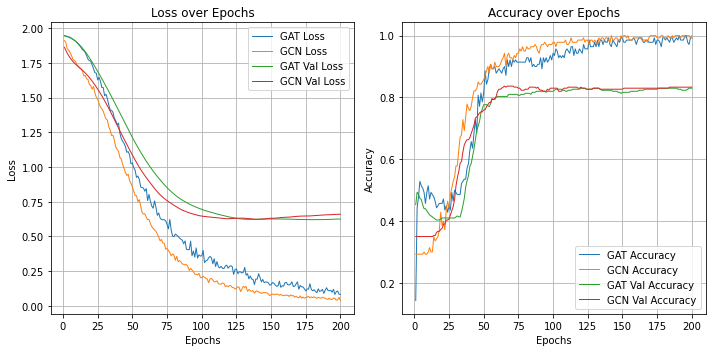

In [15]:
# Assuming epochs is a list of epoch numbers
epochs_gat = list(range(1, len(loss_gat) + 1))
epochs_gcn = list(range(1, len(loss_gcn) + 1))
# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot losses on the first subplot
axs[0].plot(epochs_gat, loss_gat, label="GAT Loss", linewidth=1)
axs[0].plot(epochs_gcn, loss_gcn, label="GCN Loss", linewidth=1)
axs[0].plot(epochs_gat, val_loss_gat, label="GAT Val Loss", linewidth=1)
axs[0].plot(epochs_gcn, val_loss_gcn, label="GCN Val Loss", linewidth=1)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss over Epochs")
axs[0].legend()
axs[0].grid(True)

# Plot accuracies on the second subplot
axs[1].plot(epochs_gat, acc_gat, label="GAT Accuracy", linewidth=1)
axs[1].plot(epochs_gcn, acc_gcn, label="GCN Accuracy", linewidth=1)
axs[1].plot(epochs_gat, val_acc_gat, label="GAT Val Accuracy", linewidth=1)
axs[1].plot(epochs_gcn, val_acc_gcn, label="GCN Val Accuracy", linewidth=1)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
# axs[1].set_ylim(0.8, 1.05)
axs[1].set_title("Accuracy over Epochs")
axs[1].legend()
axs[1].grid(True)

# Display the figure
plt.tight_layout()
plt.show()